Створимо набір даних з нашого csv файлу

In [76]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

def getDataset():
    data = pd.read_csv('Export1.csv',sep=';',encoding='cp1252')
    return data

dataset = getDataset()

Перевіримо їх на нормальність

In [77]:
dataset = dataset.drop(dataset.columns[[0, 1, 2, 3, 4, 6]], axis=1)

import scipy.stats as stats
def kolm_smirn_check(dFrame, column):
    ks_statistic, p_value = stats.kstest(dFrame[column], 'norm')
    if p_value > 0.05: return True
    return False

def pearson_check(dFrame, column):
    statistic, p_value = stats.normaltest(dFrame[column])
    if p_value > 0.05: return True
    return False

print("#1 test - Kolmagorov-Smirnov test,\n#2 test - Pearson test\n")
for c in dataset.columns:
    print('{0:<15}'.format(c + ":"),f"#1 test - {kolm_smirn_check(dataset, c)}, #2 test - {pearson_check(dataset, c)};")


#1 test - Kolmagorov-Smirnov test,
#2 test - Pearson test

ratio:          #1 test - False, #2 test - False;
gdp:            #1 test - False, #2 test - False;
population:     #1 test - False, #2 test - False;
sales_of_cigarettes_per_adult_per_day: #1 test - False, #2 test - False;
annual_co2_emissions_tonnes: #1 test - False, #2 test - False;


Перевіримо коефіцієнти корреляції

In [78]:
dataset.corr()

,ratio,gdp,population,sales_of_cigarettes_per_adult_per_day,annual_co2_emissions_tonnes
ratio,1.000000,0.774552,0.137843,-0.047489,0.090640
gdp,0.774552,1.000000,0.243990,-0.167556,0.247694
population,0.137843,0.243990,1.000000,0.045570,0.955826
sales_of_cigarettes_per_adult_per_day,-0.047489,-0.167556,0.045570,1.000000,0.003515
annual_co2_emissions_tonnes,0.090640,0.247694,0.955826,0.003515,1.000000


Розіб'ємо дані на тренувальні та тестові параметри та залежну змінну

In [79]:
from sklearn.model_selection import train_test_split

data = dataset.iloc[:,1:5]
fact = dataset['ratio']
X_train, X_test, Y_train, Y_test = train_test_split(data, fact,test_size = 0.25,random_state = 0)

Лінійна регресія.
Підготуємо всі можливі набори параметрів для моделювання та власне застосуємо лінійну регресію до кожного з них

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

X_variant_tuples = ["gdp", "population", "sales_of_cigarettes_per_adult_per_day", "annual_co2_emissions_tonnes",
    
                    ["gdp", "population", "sales_of_cigarettes_per_adult_per_day", "annual_co2_emissions_tonnes"],
                    ["gdp", "population"], ["gdp", "sales_of_cigarettes_per_adult_per_day"], ["gdp", "annual_co2_emissions_tonnes"],
                    ["population", "sales_of_cigarettes_per_adult_per_day"], ["population", "annual_co2_emissions_tonnes"],
                    ["sales_of_cigarettes_per_adult_per_day", "annual_co2_emissions_tonnes"],

                    ["gdp", "population", "sales_of_cigarettes_per_adult_per_day"], 
                    ["gdp", "population","annual_co2_emissions_tonnes"], 
                    ["gdp", "sales_of_cigarettes_per_adult_per_day", "annual_co2_emissions_tonnes"], 
                    ["population", "sales_of_cigarettes_per_adult_per_day", "annual_co2_emissions_tonnes"]]

linear_regression_models_list = []

for i in range(len(X_variant_tuples)):
    if i < 4: 
        linear_regression_models_list.append(LinearRegression().fit(X_train[X_variant_tuples[i]].to_numpy().reshape(-1,1), Y_train))
    else:
        linear_regression_models_list.append(LinearRegression().fit(X_train[X_variant_tuples[i]], Y_train))
        

Тепер для кожної нашої моделі спроєктуємо передбачення та будемо зберігати його в массиві даних

In [81]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
MSE = []
R2 = []

prediction = []

def predict_by(prediction, s):
    for i in range(len(X_variant_tuples)):
        if i < 4:
            prediction.append(s[i].predict(X_test[X_variant_tuples[i]].to_numpy().reshape(-1,1)))
        else:
            prediction.append(s[i].predict(X_test[X_variant_tuples[i]]))

    return prediction

prediction = predict_by(prediction, linear_regression_models_list)
print(prediction)

[array([0.30055253, 0.23730662, 0.25745379, 0.29168762, 0.22957692,
       0.2273141 , 0.28136563, 0.25161962, 0.19999547, 0.27672129,
       0.25436213, 0.20261434, 0.29698329, 0.25368594, 0.27720082,
       0.27064812, 0.17281835, 0.29464594, 0.20447066, 0.1987499 ,
       0.24845074, 0.29693667, 0.2385931 , 0.27593723, 0.27988533,
       0.24606003, 0.26696026, 0.29189377, 0.25759105, 0.28633219,
       0.23833473, 0.29707851, 0.18865241, 0.198939  , 0.25531339,
       0.19667341, 0.24320802, 0.2542745 , 0.25411423, 0.21622176,
       0.17010838, 0.29991786, 0.26356712, 0.25688644, 0.29162274,
       0.23655898, 0.26615908, 0.22431726, 0.26322603, 0.23545356,
       0.33166011, 0.28692438, 0.16469494, 0.32972123, 0.26730507,
       0.21052278, 0.16942938, 0.31572451, 0.28569374, 0.23780758,
       0.26894609, 0.26881451, 0.27664023, 0.22802073, 0.27226238,
       0.22874924, 0.23779891, 0.30209134, 0.22006535, 0.17234289,
       0.26618578, 0.25531743, 0.25518279, 0.20224889, 0.1704

Для кожного з передбачень обрахуємо MSE та R2.
Для MSE побудужмо графік для наочності та аби зрозуміти, яка сама модель є ефективнішою

[0.0015067597287360514, 0.003852151494575099, 0.004026399727361655, 0.003874289757312367, 0.0013026028278516732, 0.0014833530593858168, 0.0014526232611095815, 0.0014306078219743733, 0.004008792266713763, 0.003795901989735636, 0.004022878500132977, 0.0014218584023596168, 0.0013379169285308683, 0.001371339445990647, 0.003954269999128051]


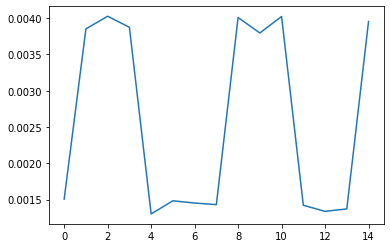

In [82]:
for i in range(len(prediction)):
    MSE.append(mean_squared_error(Y_test,prediction[i]))
    R2.append(r2_score(Y_test,prediction[i]))

import matplotlib.pyplot as plt
print(MSE)
#plt.plot(R2)
plt.plot(MSE)
plt.show()

Програмно порахуємо та визначимо, яка модель є найкращою

In [83]:
indexMinMSE = np.sum((np.array(prediction)- Y_test.to_numpy())**2,axis = 1).argmin()
MinMSE = np.sum((np.array(prediction) - Y_test.to_numpy())**2, axis = 1)
#print(MinMSE)
#print(indexMinMSE)
print("Best model is:")
print(f"linear model by {X_variant_tuples[indexMinMSE]} params")

Best model is:
linear model by ['gdp', 'population', 'sales_of_cigarettes_per_adult_per_day', 'annual_co2_emissions_tonnes'] params


In [84]:
from sklearn.linear_model import LogisticRegression

Тепер, знаючи, яка модель є найкращою, за допомогою кастомної функції, продемонструємо графік Learning Curve

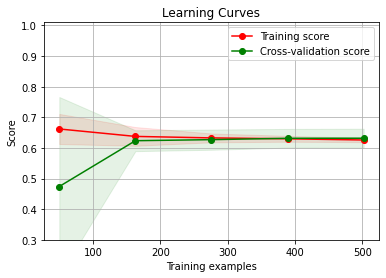

In [85]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(linear_regression_models_list[4], "Learning Curves", X_train, Y_train, (0.3, 1.01), cv=cv, n_jobs=4)
plt.show()
#plot_learning_curve(linear_regression_models_list[12], "Learning Curves", X_train, Y_train, (0.3, 1.01), cv=cv, n_jobs=4)
#plt.show()

Random Forest Regression.
Для кожного кортежу застосуємо дану модель

In [86]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regression_model_list = []

#model = RandomForestRegressor(n_estimators=500, max_features=5).fit(X,y)

for i in range(len(X_variant_tuples)):
    if i < 4: 
        random_forest_regression_model_list.append(RandomForestRegressor(n_estimators=300, max_features=5).fit(X_train[X_variant_tuples[i]].to_numpy().reshape(-1,1), Y_train))
    else:
        random_forest_regression_model_list.append(RandomForestRegressor(n_estimators=300, max_features=5).fit(X_train[X_variant_tuples[i]], Y_train))
        

In [87]:
random_forest_prediction = []
random_forest_prediction = predict_by(random_forest_prediction, random_forest_regression_model_list)
print(random_forest_prediction)

[array([0.32726067, 0.23907256, 0.27883397, 0.27614976, 0.22184051,
       0.2549757 , 0.26725281, 0.24584823, 0.15882759, 0.29356689,
       0.27720889, 0.15360171, 0.31426732, 0.28851786, 0.3088842 ,
       0.3080507 , 0.13289613, 0.30800265, 0.1904897 , 0.15489619,
       0.26659574, 0.31426732, 0.26636289, 0.29622226, 0.28740969,
       0.23602149, 0.26930174, 0.31398242, 0.27926714, 0.27822116,
       0.25947962, 0.32311163, 0.14976885, 0.15814932, 0.28837029,
       0.20518092, 0.26533135, 0.27333568, 0.26449234, 0.20529252,
       0.18665397, 0.31696884, 0.30296653, 0.23309205, 0.27620696,
       0.27672111, 0.28632698, 0.19865245, 0.24677677, 0.23501233,
       0.26568384, 0.2711908 , 0.14454743, 0.27129459, 0.26239528,
       0.21659781, 0.15442468, 0.30586953, 0.27381795, 0.26828581,
       0.27951646, 0.2866103 , 0.27310379, 0.27497522, 0.30680418,
       0.27671559, 0.26828581, 0.26252064, 0.25360334, 0.1419666 ,
       0.2865635 , 0.28837029, 0.29077025, 0.19696662, 0.1360

[0.001302158659991345, 0.0033798107167065145, 0.004741493302564858, 0.0032614628173269333, 0.0002625669231999411, 0.00041449226726432, 0.0007688248932839592, 0.0005071298789650197, 0.0016392767178166016, 0.0009377544926821164, 0.0020702438136682147, 0.00027482158430672384, 0.0003229796418071324, 0.00039724113761139624, 0.0007205045735169769]


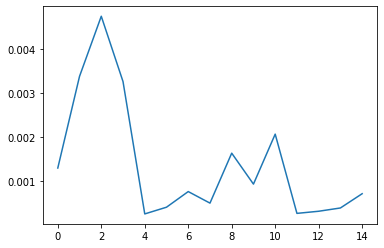

In [88]:
MSE_forest = []
R2_forest = []
for i in range(len(random_forest_prediction)):
    MSE_forest.append(mean_squared_error(Y_test,random_forest_prediction[i]))
    R2_forest.append(r2_score(Y_test,random_forest_prediction[i]))

print(MSE_forest)
#plt.plot(R2)
plt.plot(MSE_forest)
plt.show()

In [118]:
indexMinMSE_forest = np.sum((np.array(random_forest_prediction)- Y_test.to_numpy())**2,axis = 1).argmin()
MinMSE_forest = np.sum((np.array(random_forest_prediction) - Y_test.to_numpy())**2, axis = 1)
#print(MinMSE)
print(indexMinMSE)
print("Best model is:")
print(f"Random Forest model by {X_variant_tuples[indexMinMSE_forest]} params")

[0.27345332 0.70976025 0.99571359 0.68490719 0.05513905 0.08704338
 0.16145323 0.10649727 0.34424811 0.19692844 0.4347512  0.05771253
 0.06782572 0.08342064 0.15130596]
Best model is:
Random Forest model by ['gdp', 'population', 'sales_of_cigarettes_per_adult_per_day', 'annual_co2_emissions_tonnes'] params


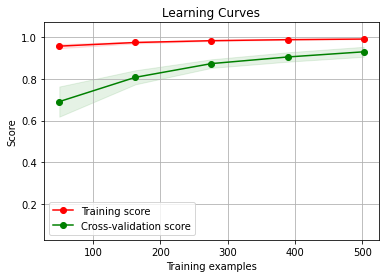

In [90]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(random_forest_regression_model_list[4], "Learning Curves", X_train, Y_train, (0.03, 1.07), cv=cv, n_jobs=4)
plt.show()

The k-Nearest Neighbors (kNN) Algorithm

In [106]:
from sklearn.neighbors import KNeighborsRegressor

k_Nearest_regression_model_list = []

#model = RandomForestRegressor(n_estimators=500, max_features=5).fit(X,y)

for i in range(len(X_variant_tuples)):
    if i < 4: 
        k_Nearest_regression_model_list.append(KNeighborsRegressor(n_neighbors=150).fit(X_train[X_variant_tuples[i]].to_numpy().reshape(-1,1), Y_train))
    else:
        k_Nearest_regression_model_list.append(KNeighborsRegressor(n_neighbors=150).fit(X_train[X_variant_tuples[i]], Y_train))
        

In [107]:
k_Nearest_prediction = []
k_Nearest_prediction = predict_by(k_Nearest_prediction, k_Nearest_regression_model_list)
print(k_Nearest_prediction)

[array([0.29633801, 0.25338409, 0.2764533 , 0.29488049, 0.24125083,
       0.23911581, 0.29494863, 0.26822879, 0.18939089, 0.29291771,
       0.27190739, 0.19259336, 0.29492533, 0.27082778, 0.29344647,
       0.29163656, 0.17706329, 0.29502335, 0.19664069, 0.18580012,
       0.26454717, 0.29492533, 0.25520315, 0.29220376, 0.29488187,
       0.26291505, 0.28924421, 0.29488049, 0.27665172, 0.29503691,
       0.25520315, 0.2951047 , 0.17706329, 0.18695413, 0.27439949,
       0.18164426, 0.25933349, 0.27134998, 0.27134998, 0.21736265,
       0.17706329, 0.29594118, 0.28559515, 0.27653551, 0.29488049,
       0.2521984 , 0.2888385 , 0.23593854, 0.28496915, 0.24970684,
       0.29956489, 0.29510231, 0.17706329, 0.29956489, 0.28954549,
       0.20191062, 0.17706329, 0.3008148 , 0.29520251, 0.25406899,
       0.2904744 , 0.2904744 , 0.29291771, 0.2391679 , 0.29196069,
       0.24079879, 0.25406899, 0.29690774, 0.22665509, 0.17706329,
       0.2888385 , 0.27439949, 0.27410133, 0.19259336, 0.1770

[0.0010802690476732235, 0.003654532619633476, 0.0038980042817149323, 0.00328688337748756, 0.0032818870978392626, 0.003654532619633476, 0.0010802690476732235, 0.00328688337748756, 0.003654532619633476, 0.0032818870978392626, 0.00328688337748756, 0.003654532619633476, 0.0032818870978392626, 0.00328688337748756, 0.0032818870978392626]


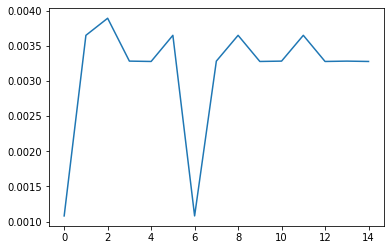

In [108]:
MSE_k_Nearest = []
R2_k_Nearest = []
for i in range(len(k_Nearest_prediction)):
    MSE_k_Nearest.append(mean_squared_error(Y_test,k_Nearest_prediction[i]))
    R2_k_Nearest.append(r2_score(Y_test,k_Nearest_prediction[i]))

print(MSE_k_Nearest)
#plt.plot(R2)
plt.plot(MSE_k_Nearest)
plt.show()



In [139]:
indexMinMSE_k_Nearest = np.sum((np.array(k_Nearest_prediction)- Y_test.to_numpy())**2,axis = 1).argmin()
MinMSE_k_Nearest = np.sum((np.array(k_Nearest_prediction) - Y_test.to_numpy())**2, axis = 1)
print(MinMSE_k_Nearest)
print(indexMinMSE_k_Nearest)
print("Best model is:")
print(f"k Nearest model by {X_variant_tuples[indexMinMSE_k_Nearest]} params")

[0.2268565  0.76745185 0.8185809  0.69024551 0.68919629 0.76745185
 0.2268565  0.69024551 0.76745185 0.68919629 0.69024551 0.76745185
 0.68919629 0.69024551 0.68919629]
0
Best model is:
k Nearest model by gdp params


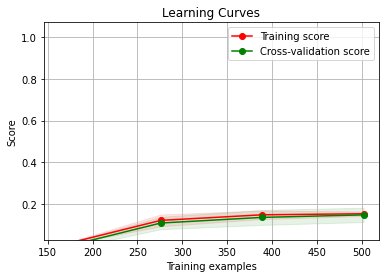

In [140]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(k_Nearest_regression_model_list[4], "Learning Curves", X_train, Y_train, (0.03, 1.07), cv=cv, n_jobs=4)
plt.show()

Support Vector Machines

In [132]:
from sklearn.ensemble import GradientBoostingRegressor

GradientBoostingRegressor_regression_model_list = []

#model = RandomForestRegressor(n_estimators=500, max_features=5).fit(X,y)
for i in range(len(X_variant_tuples)):
    if i < 4: 
       GradientBoostingRegressor_regression_model_list.append(GradientBoostingRegressor(random_state=0).fit(X_train[X_variant_tuples[i]].to_numpy().reshape(-1,1), Y_train))
    else:
        GradientBoostingRegressor_regression_model_list.append(GradientBoostingRegressor(random_state=0).fit(X_train[X_variant_tuples[i]], Y_train))

In [133]:
GradientBoostingRegressor_prediction = []
GradientBoostingRegressor_prediction = predict_by(GradientBoostingRegressor_prediction, GradientBoostingRegressor_regression_model_list)
print(GradientBoostingRegressor_prediction)

[array([0.29867495, 0.25206465, 0.27349097, 0.29909807, 0.24386612,
       0.25583816, 0.28983752, 0.26047406, 0.17000057, 0.29608771,
       0.27349097, 0.17438159, 0.29867495, 0.27349097, 0.29608771,
       0.30424301, 0.144195  , 0.29867495, 0.17613036, 0.17000057,
       0.26047406, 0.29867495, 0.25475788, 0.29608771, 0.2913642 ,
       0.25121578, 0.27965329, 0.29909807, 0.27349097, 0.28133025,
       0.25475788, 0.29867495, 0.16053236, 0.17000057, 0.27349097,
       0.17524866, 0.25250737, 0.27349097, 0.27349097, 0.2139514 ,
       0.16488682, 0.29867495, 0.29179237, 0.27349097, 0.29909807,
       0.25677559, 0.29118754, 0.22298549, 0.27069162, 0.25370436,
       0.27313626, 0.28133025, 0.1481142 , 0.27313626, 0.27965329,
       0.21463796, 0.14821064, 0.30309341, 0.28499422, 0.25475788,
       0.29156947, 0.29156947, 0.29608771, 0.25583816, 0.30213402,
       0.25864135, 0.25475788, 0.29867495, 0.23933377, 0.144195  ,
       0.29118754, 0.27349097, 0.27349097, 0.17438159, 0.1231

[0.0010190075592278716, 0.002415266531031726, 0.004567625541823404, 0.002307339469792709, 0.0003774600425782712, 0.00048558652914810856, 0.0007790543846132895, 0.0005642446384590425, 0.002110373545442584, 0.0009838206008292035, 0.0020255957954175615, 0.00041244237559842157, 0.0003880526301308858, 0.0004729935962665314, 0.0009929554451943393]


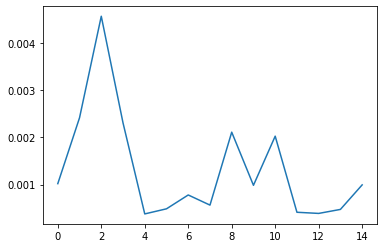

In [135]:
MSE_GradientBoostingRegressor = []
R2_GradientBoostingRegressor = []
for i in range(len(GradientBoostingRegressor_prediction)):
    MSE_GradientBoostingRegressor.append(mean_squared_error(Y_test,GradientBoostingRegressor_prediction[i]))
    R2_GradientBoostingRegressor.append(r2_score(Y_test,GradientBoostingRegressor_prediction[i]))

print(MSE_GradientBoostingRegressor)
#plt.plot(R2)
plt.plot(MSE_GradientBoostingRegressor)
plt.show()

In [138]:
indexMinMSE_GradientBoostingRegressor = np.sum((np.array(GradientBoostingRegressor_prediction)- Y_test.to_numpy())**2,axis = 1).argmin()
MinMSE_GradientBoostingRegressor = np.sum((np.array(GradientBoostingRegressor_prediction) - Y_test.to_numpy())**2, axis = 1)
print(MinMSE_GradientBoostingRegressor)
print(indexMinMSE_GradientBoostingRegressor)
print("Best model is:")
print(f"k Nearest model by {X_variant_tuples[indexMinMSE_GradientBoostingRegressor]} params")

[0.21399159 0.50720597 0.95920136 0.48454129 0.07926661 0.10197317
 0.16360142 0.11849137 0.44317844 0.20660233 0.42537512 0.0866129
 0.08149105 0.09932866 0.20852064]
4
Best model is:
k Nearest model by ['gdp', 'population', 'sales_of_cigarettes_per_adult_per_day', 'annual_co2_emissions_tonnes'] params


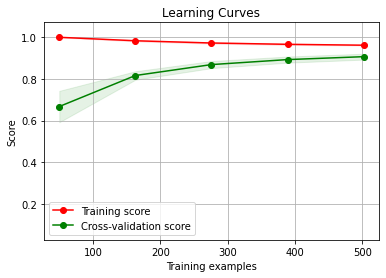

In [141]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(GradientBoostingRegressor_regression_model_list[4], "Learning Curves", X_train, Y_train, (0.03, 1.07), cv=cv, n_jobs=4)
plt.show()